# Simulations

These are same useful functions to import. Since we are calculating the statistical power over all the tests for all the simulations, we can just use a wild card import from the respective modules

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from hyppo.sims import *

In [5]:
import seaborn as sns
sns.color_palette('Set1')
sns.set(color_codes=True, style='white', context='talk', font_scale=2)

These are some constants that are used in this notebook. If running these notebook, please only manipulate these constants if you are not running more tests. They define the sample sizes tested upon and the number of replications. The simulations tested over and the independence tests tested over are defined also.

In [6]:
NOISY = 100
NO_NOISE = 1000

In [7]:
indep_sims = [
    (linear, "Linear"),
    (exponential, "Exponential"),
    (cubic, "Cubic"),
    (joint_normal, "Joint Normal"),
    (step, "Step"),
    (quadratic, "Quadratic"),
    (w_shaped, "W-Shaped"),
    (spiral, "Spiral"),
    (uncorrelated_bernoulli, "Bernoulli"),
    (logarithmic, "Logarithmic"),
    (fourth_root, "Fourth Root"),
    (sin_four_pi, "Sine 4\u03C0"),
    (sin_sixteen_pi, "Sine 16\u03C0"),
    (square, "Square"),
    (two_parabolas, "Two Parabolas"),
    (circle, "Circle"),
    (ellipse, "Ellipse"),
    (diamond, "Diamond"),
    (multiplicative_noise, "Multiplicative"),
    (multimodal_independence, "Independence")
]

The following code plots the simulation with noise where applicable in blue overlayed with the simulation with no noise in red. For specific equations for each simulation, please refer to the documentation about each simulation.

In [14]:
N = 500
P = 1
DEGREE = 60

def _normalize(x, y):
    """Normalize input data matricies."""
    x = x / np.max(np.abs(x))
    y = y / np.max(np.abs(y))
    return x, y


def _2samp_rotate(sim, x, y, p, degree=120, pow_type="samp"):
    angle = np.radians(degree)
    data = np.hstack([x, y])
    same_shape = [
        "joint_normal",
        "logarithmic",
        "sin_four_pi",
        "sin_sixteen_pi",
        "two_parabolas",
        "square",
        "diamond",
        "circle",
        "ellipse",
        "multiplicative_noise",
        "multimodal_independence",
    ]
    if sim.__name__ in same_shape:
        rot_shape = 2 * p
    else:
        rot_shape = p + 1
    rot_mat = np.identity(rot_shape)
    if pow_type == "dim":
        if sim.__name__ not in [
            "exponential",
            "cubic",
            "spiral",
            "uncorrelated_bernoulli",
            "fourth_root",
            "circle",
        ]:
            for i in range(rot_shape):
                mat = np.random.normal(size=(rot_shape, 1))
                mat = mat / np.sqrt(np.sum(mat ** 2))
                if i == 0:
                    rot = mat
                else:
                    rot = np.hstack([rot, mat])
                rot_mat, _ = np.linalg.qr(rot)
                if (p % 2) == 1:
                    rot_mat[0] *= -1
        else:
            rot_mat[np.ix_((0, -1), (0, -1))] = np.array(
                [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
            )
    elif pow_type == "samp":
        rot_mat[np.ix_((0, 1), (0, 1))] = np.array(
            [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
        )
    else:
        raise ValueError("pow_type not a valid flag ('dim', 'samp')")
    rot_data = (rot_mat @ data.T).T

    if sim.__name__ in [
        "joint_normal",
        "logarithmic",
        "sin_four_pi",
        "sin_sixteen_pi",
        "two_parabolas",
        "square",
        "diamond",
        "circle",
        "ellipse",
        "multiplicative_noise",
        "multimodal_independence",
    ]:
        x_rot, y_rot = np.hsplit(rot_data, 2)
    else:
        x_rot, y_rot = np.hsplit(rot_data, [-1])

    return x_rot, y_rot


def plot_sims():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28,24))
    count = 0
    
    sim_markers = [
        "+",
        "x"
    ]
    custom_color = [
        "#969696",
        "#525252"
    ]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim, sim_title = indep_sims[count]
            if sim.__name__ == "multimodal_independence":
                x1, y1 = sim(N, P)
                x2, y2 = sim(N, P)
                x3, y3 = sim(N, P)
            else:
                if sim.__name__ == "multiplicative_noise":
                    x1, y1 = sim(N, P)
                else:
                    x1, y1 = sim(N, P, noise=False)
                if sim.__name__ not in ["linear", "exponential", "cubic"]:
                    pass
                else:
                    x1, y1 = _normalize(x1, y1)
                x2, y2 = _2samp_rotate(sim, x1, y1, P, degree=DEGREE, pow_type="samp")
                x3, y3 = _2samp_rotate(sim, x1, y1, P, degree=-DEGREE, pow_type="samp")
            col.scatter(x1, y1, marker="1", color="#d9d9d9", label="Sample 1")
            col.scatter(x2, y2, marker="+", color="#969696", label="Sample 2")
            col.scatter(x3, y3, marker="x", color="#525252", label="Sample 3")
            col.set_title('{}'.format(sim_title), fontsize=35)
            col.set_xticks([])
            col.set_yticks([])
            if sim.__name__ == "multimodal_independence":
                col.set_ylim([-2, 2])
            sns.despine(left=True, bottom=True, right=True)
                
    leg = plt.legend(bbox_to_anchor=(0.5, 0.1), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)
    plt.subplots_adjust(hspace=.5)
    plt.savefig('../benchmarks/figs/3samp_simulations.pdf', transparent=True, bbox_inches='tight')

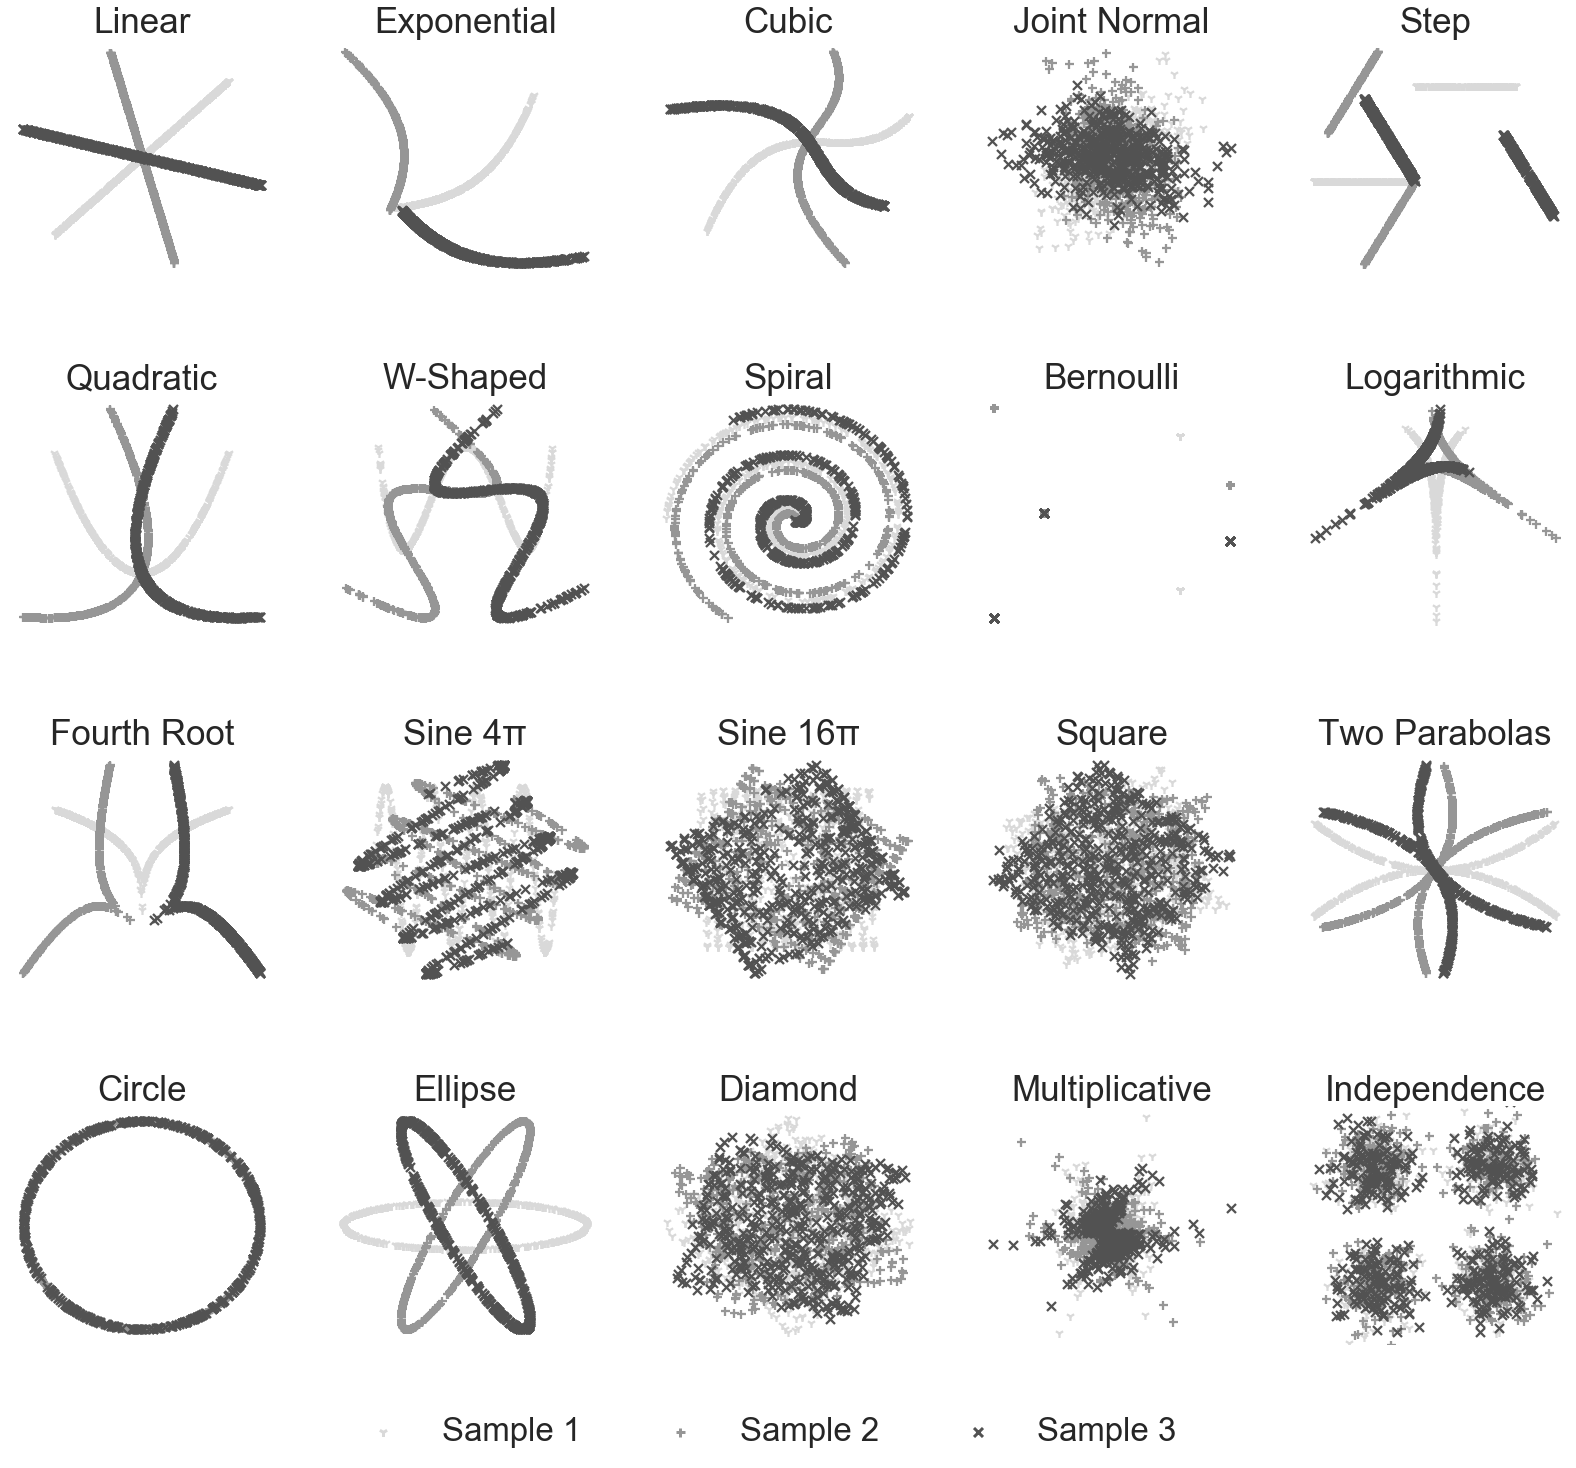

In [15]:
plot_sims()